<a href="https://colab.research.google.com/github/DavidTitoInfantas/Project_Atlas_Technologies/blob/main/Analise_Asignaturas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analise Projeto Atlas

###Lib's

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

In [2]:
def metricas(scores,target):
    return pd.DataFrame({
        'KS'   : [ks2(scores,target)],
        'ROC'  : [roc_auc_score(y_score=scores,y_true=target)],
        'GINI' : [2 * roc_auc_score(y_score=scores,y_true=target) - 1]
          })
    
def ks2(score, alvo):
    b2 = pd.crosstab(score, alvo, rownames = ['score']).reset_index()
    if len(np.unique(alvo)) > 1:
        freq_bom = b2.iloc[:,1]/sum(b2.iloc[:,1])
        freq_mau = b2.iloc[:,2]/sum(b2.iloc[:,2])
        ac_bom = np.cumsum(freq_bom)
        ac_mau = np.cumsum(freq_mau)
        diff = np.abs(ac_bom - ac_mau).round(7)
        ks = diff.max() * 100
    else:
        ks = 0
    return ks

def tabela_geral(modelos, X,y,nomes):
  lista = []
  noms = []
  for i in range(len(modelos)):
    tab = metricas(modelos[i].predict_proba(X)[:,0],y)
    lista.append(tab)
    nom = nomes[i]
    noms.append(nom)   
  tabela_g = pd.concat([lista[0],lista[1]],ignore_index=True)
  tabela_g['modelo']= noms
  return tabela_g[['modelo', 'KS','ROC','GINI']]  

def plot_scores(df, score_base='Score_solucao'):
    num_bins = 10 
    plt.figure(figsize=(8, 4))
    plt.hist(df[score_base], num_bins, facecolor='blue', alpha=0.4,label=str(score_base))
    plt.legend(prop={'size': 10})
    plt.xlabel("Scores")
    plt.ylabel("Frequencia")
    tittle = str('Histogram')
    plt.title("{}".format(str(tittle)))
    plt.show()

import matplotlib.pyplot as plt
def plot_graph(x,y,x_nome,y_nome,tittle):
  fig = plt.figure(figsize=(15, 4))
  ax = fig.add_axes([0,0,1,1])
  ax.bar(x,y,label=str(x_nome))
  plt.legend(prop={'size': 10})
  plt.xlabel(str(x_nome))
  plt.ylabel(str(y_nome))
  plt.title(str(tittle))
  plt.show()

###Download the data set

In [3]:
df = pd.read_excel('/content/drive/MyDrive/Pratica_machine_learning/projeto_atlas/Data/dados_assinaturas.xlsx')

In [4]:
df.head(5)

,Profile ID,Profile Created At,Profile Deleted At,Plan Code,Payment Method,Charge Value,Subscription Status,Charge Day,Last Charge At,Next Charge At,Subscription Canceled At,Cancel Reason,Subscripion Created At,Estado
0,473128,2021-07-16 12:45:36,NaT,plano D,CREDIT_CARD,59.9,DRAFT,19,NaN,NaT,NaT,NaN,2021-07-19 18:45:21,Rio de Janeiro
1,315949,2021-07-14 11:01:43,NaT,plano A,CREDIT_CARD,89.9,CANCELED,23,2021-07-23,2021-07-23,2021-07-23,PAYMENT FAILED,2021-07-23 20:05:14,Rio de Janeiro
2,293763,2018-12-21 04:34:25,NaT,plano B,CREDIT_CARD,359.9,CANCELED,24,2021-07-24,2021-07-24,2021-07-27,USER SUSPENDED,2021-07-24 21:34:55,Bahia
3,124763,2021-01-24 07:52:57,NaT,plano D,CREDIT_CARD,59.9,CANCELED,25,NaN,NaT,2021-07-04,ADMIN CANCELED,2021-07-25 01:04:58,Rio de Janeiro
4,391446,2021-01-24 07:52:57,NaT,plano A,CREDIT_CARD,99.9,CANCELED,25,NaN,NaT,2021-07-04,ADMIN CANCELED,2021-07-25 01:05:05,Rio de Janeiro


###Exploratory Data Analysis (EDA)


In [5]:
print('-'*20, 'General information data of the data frame', '-'*20, '\n')
print('Number of rows = {}'.format(df.shape[0]))
print('Number of columns = {}'.format(df.shape[1]),'\n')
print('head of columns = {}'.format(df.columns.values))

print('-'*20, 'Information of type for column', '-'*20, '\n')
print(df.info())

-------------------- General information data of the data frame -------------------- 

Number of rows = 2027
Number of columns = 14 

head of columns = ['Profile ID' 'Profile Created At' 'Profile Deleted At' 'Plan Code'
 'Payment Method' 'Charge Value' 'Subscription Status' 'Charge Day'
 'Last Charge At' 'Next Charge At' 'Subscription Canceled At'
 'Cancel Reason' 'Subscripion Created At ' 'Estado']
-------------------- Information of type for column -------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2027 entries, 0 to 2026
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Profile ID                2027 non-null   int64         
 1   Profile Created At        2027 non-null   datetime64[ns]
 2   Profile Deleted At        130 non-null    datetime64[ns]
 3   Plan Code                 2027 non-null   object        
 4   Payment Method            2027 non-nul

In [6]:
df.columns

Index(['Profile ID', 'Profile Created At', 'Profile Deleted At', 'Plan Code',
       'Payment Method', 'Charge Value', 'Subscription Status', 'Charge Day',
       'Last Charge At', 'Next Charge At', 'Subscription Canceled At',
       'Cancel Reason', 'Subscripion Created At ', 'Estado'],
      dtype='object')

In [7]:
print('-'*20, 'Percentage of null data', '-'*20, '\n')
df.isna().sum()/df.shape[0]*100

-------------------- Percentage of null data -------------------- 



Profile ID                   0.000000
Profile Created At           0.000000
Profile Deleted At          93.586581
Plan Code                    0.000000
Payment Method               0.000000
Charge Value                 0.000000
Subscription Status          0.000000
Charge Day                   0.000000
Last Charge At              45.831278
Next Charge At              45.831278
Subscription Canceled At    21.213616
Cancel Reason               20.917612
Subscripion Created At       0.000000
Estado                       0.000000
dtype: float64

---------- Percentage of Plan Code ----------
plano A    33.645782
plano B    22.200296
plano C    20.374938
plano D    19.092255
plano E     4.686729
Name: Plan Code, dtype: float64 

---------- Percentage of Payment Method ----------
CREDIT_CARD    100.0
Name: Payment Method, dtype: float64 

---------- Percentage of Subscription Status ----------
CANCELED         78.786384
ACTIVE           18.253577
DRAFT             2.664036
CANCEL QUEUED     0.296004
Name: Subscription Status, dtype: float64 

---------- Percentage of Cancel Reason ----------
PAYMENT FAILED    48.889985
USER SUSPENDED    17.217563
USER CANCELED      3.749383
ADMIN CANCELED     3.502713
USER PENALTY       3.354711
USER DELETED       1.430686
CHARGEBACK         0.493340
USER BANED         0.345338
MOIP CANCELED      0.098668
Name: Cancel Reason, dtype: float64 

---------- Percentage of Estado ----------
São Paulo              21.460286
Rio Grande do Sul      12.530834
Minas Gerais           11.198816
Santa Catarina

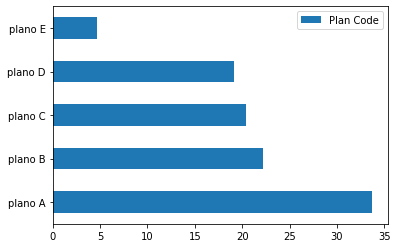

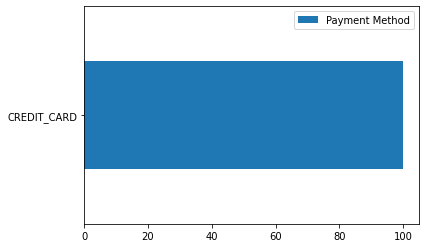

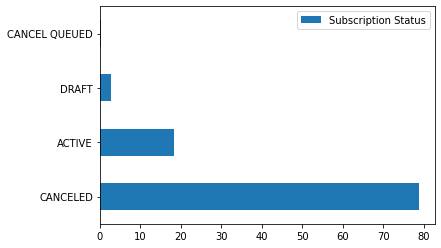

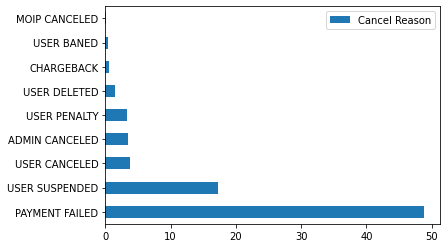

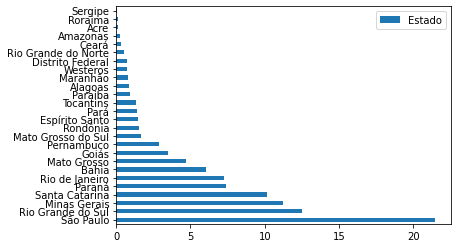

In [8]:
li_1 = ['Plan Code','Payment Method',
        'Subscription Status','Cancel Reason',
        'Estado']

for i in li_1:
  print('-'*10, 'Percentage of',format(i), '-'*10)
  print(df[i].value_counts()/df.shape[0]*100, '\n')
  a = pd.DataFrame(df[i].value_counts()/df.shape[0]*100)
  a.plot(kind='barh')

In [9]:
print('-'*10, 'Mean recharge values ​​by region', '-'*10)
df.groupby('Estado')['Charge Value'].mean().sort_values(ascending = False ).head(20)

---------- Mean recharge values ​​by region ----------


Estado
Ceará                 257.614286
Westeros              245.766667
Mato Grosso do Sul    200.194118
Rondônia              190.125806
Amazonas              188.900000
Tocantins             177.196296
Paraná                176.346667
Acre                  167.900000
Alagoas               167.194118
Minas Gerais          162.710573
Rio de Janeiro        161.831973
Distrito Federal      161.233333
Goiás                 154.857746
Santa Catarina        154.215534
São Paulo             144.033333
Rio Grande do Sul     142.435433
Mato Grosso           133.700000
Pará                  128.007143
Pernambuco            124.710345
Paraiba               122.215789
Name: Charge Value, dtype: float64

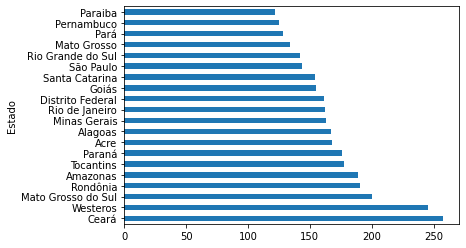

In [10]:
df.groupby('Estado')['Charge Value'].mean().sort_values(ascending = False ).head(20).plot(kind='barh') 

In [11]:
pd.crosstab(df['Subscription Status'],df['Estado'], margins=True,margins_name='Total').sort_values(by='Total', axis=1, ascending = False )

Estado,Total,São Paulo,Rio Grande do Sul,Minas Gerais,Santa Catarina,Paraná,Rio de Janeiro,Bahia,Mato Grosso,Goiás,Pernambuco,Mato Grosso do Sul,Rondônia,Espírito Santo,Pará,Tocantins,Paraiba,Alagoas,Maranhão,Distrito Federal,Westeros,Rio Grande do Norte,Ceará,Amazonas,Roraima,Acre,Sergipe
Subscription Status,,,,,,,,,,,,,,,,,,,,,,,,,,,
ACTIVE,370,86,48,40,41,43,18,14,15,13,9,9,4,7,4,7,4,1,1,4,0,1,1,0,0,0,0
CANCEL QUEUED,6,0,2,0,1,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CANCELED,1597,336,198,185,159,100,127,105,77,57,40,25,26,23,24,20,15,15,14,8,15,10,6,5,3,3,1
DRAFT,54,13,6,2,5,7,2,2,1,1,9,0,1,0,0,0,0,1,1,3,0,0,0,0,0,0,0
Total,2027,435,254,227,206,150,147,122,95,71,58,34,31,30,28,27,19,17,16,15,15,11,7,5,3,3,1


In [12]:
pd.crosstab(df['Estado'],df['Plan Code'], margins=True,margins_name='Total').sort_values(by = 'Total', axis=0,ascending=False).head(10)

Plan Code,plano A,plano B,plano C,plano D,plano E,Total
Estado,,,,,,
Total,682,450,413,387,95,2027
São Paulo,144,87,89,91,24,435
Rio Grande do Sul,81,56,66,45,6,254
Minas Gerais,85,55,41,33,13,227
Santa Catarina,81,48,30,37,10,206
Paraná,56,47,26,16,5,150
Rio de Janeiro,30,38,35,34,10,147
Bahia,37,12,36,30,7,122
Mato Grosso,30,16,16,28,5,95


In [13]:
pd.crosstab(df['Subscription Status'],
            df['Plan Code'], 
                            margins=True,
                            margins_name='Total'
                            ).sort_values(by = 'Total', 
                                          axis=0,ascending=False
                                          ).head(15)

Plan Code,plano A,plano B,plano C,plano D,plano E,Total
Subscription Status,,,,,,
Total,682,450,413,387,95,2027
CANCELED,532,362,326,298,79,1597
ACTIVE,136,78,71,74,11,370
DRAFT,13,9,15,12,5,54
CANCEL QUEUED,1,1,1,3,0,6


####Analysis of people who canceled the plan

In [14]:
df_canc = df[df['Subscription Status']=='CANCELED']

In [15]:
df_canc['safra'] = df_canc['Subscription Canceled At'].apply(lambda x: pd.to_datetime(x, format ='%Y-%m').strftime('%y-%m'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
print('-'*10, 'Number of cancellations per month', '-'*10)
df_canc.groupby('safra')['Subscription Status'].value_counts()

---------- Number of cancellations per month ----------


safra  Subscription Status
21-06  CANCELED                10
21-07  CANCELED               519
21-08  CANCELED                 1
21-09  CANCELED               545
21-10  CANCELED               522
Name: Subscription Status, dtype: int64

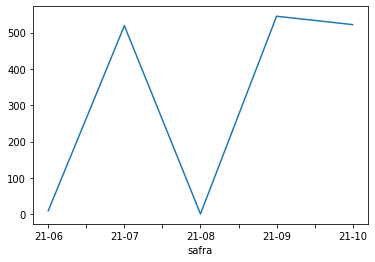

In [17]:
df_canc.groupby('safra')['safra'].count().plot()

In [18]:
print('-'*10, 'Number of people who canceled the plan ​​by region', '-'*10)
df_canc.groupby('Estado')['Estado'].count().sort_values(
                                                          ascending=False
                                                          ).head(10)

---------- Number of people who canceled the plan ​​by region ----------


Estado
São Paulo            336
Rio Grande do Sul    198
Minas Gerais         185
Santa Catarina       159
Rio de Janeiro       127
Bahia                105
Paraná               100
Mato Grosso           77
Goiás                 57
Pernambuco            40
Name: Estado, dtype: int64

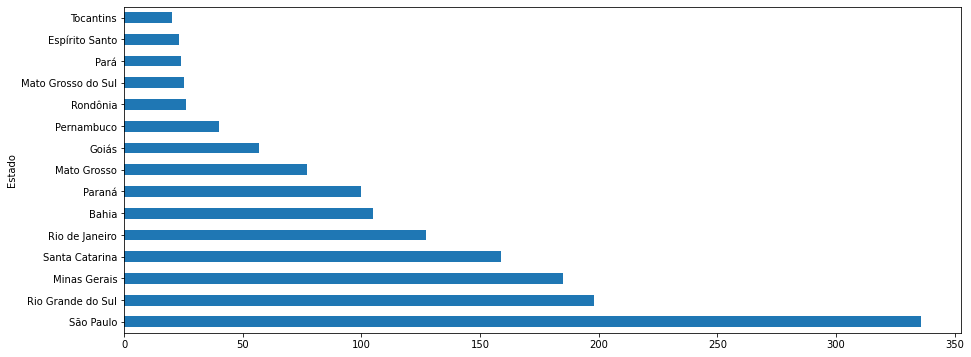

In [19]:
plt.figure(figsize=(15,6))
df_canc.groupby('Estado')['Estado'].count().sort_values(
                                                          ascending=False
                                                          ).head(15).plot(kind='barh')

In [20]:
print( '* Reason for canceling the plan *','\n')
(df_canc.groupby(['Cancel Reason'])['Cancel Reason'].count()/df['Cancel Reason'].count()*100).sort_values(
                                                          ascending=False
                                                          ).head(5)

* Reason for canceling the plan * 



Cancel Reason
PAYMENT FAILED    61.821585
USER SUSPENDED    21.459763
USER CANCELED      4.741110
ADMIN CANCELED     4.429195
USER PENALTY       4.179663
Name: Cancel Reason, dtype: float64

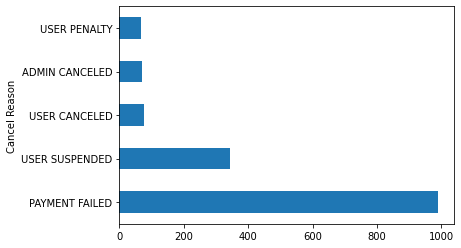

In [21]:
df_canc.groupby(['Cancel Reason'])['Cancel Reason'].count().sort_values(
                                                          ascending=False
                                                          ).head(5).plot(kind='barh')

##Feature selection

In [22]:
df.drop(['Profile ID', 'Profile Created At', 'Profile Deleted At', 
       'Payment Method', 'Last Charge At', 'Next Charge At', 
       'Subscription Canceled At', 'Subscripion Created At '],axis=1,inplace=True)

In [23]:
df = df.fillna(0)
df.replace({'PAYMENT FAILED':1, 'USER SUSPENDED':2,},inplace=True)
df.replace([['ADMIN CANCELED',
       'MOIP CANCELED', 'USER DELETED', 'USER PENALTY', 'USER CANCELED',
       'CHARGEBACK', 'USER BANED']],3,inplace=True)

In [24]:
df.replace({'ACTIVE':0, 'DRAFT':0, 'CANCELED':1, 'CANCEL QUEUED':0},inplace=True)

In [25]:
df.replace({'plano D':1, 'plano A':2, 'plano B':3, 'plano C':4, 'plano E':5},inplace=True)

In [26]:
df.replace({'São Paulo':1, 'Rio Grande do Sul':2, 'Minas Gerais':3, 'Santa Catarina':4},inplace=True)
df.replace([['Rio de Janeiro', 'Bahia' , 'Mato Grosso', 'Paraná',
             'Goiás', 'Espírito Santo', 'Distrito Federal',
             'Mato Grosso do Sul', 'Westeros', 'Roraima', 'Tocantins',
             'Rio Grande do Norte', 'Rondônia', 'Paraiba', 'Maranhão',
             'Amazonas', 'Pará', 'Alagoas', 'Pernambuco', 'Ceará', 'Acre',
             'Sergipe']],5,inplace=True)

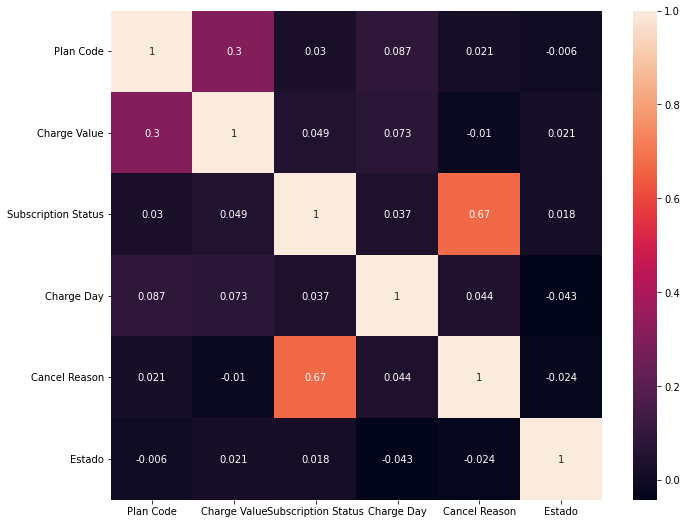

In [27]:
#Analise da correlação entre as features
#Analise da correlação entre as features com o target 
import matplotlib.pyplot as plt
import seaborn as sn
corrMatrix = df.corr()
plt.figure(figsize=(11, 9))
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [28]:
df.columns

Index(['Plan Code', 'Charge Value', 'Subscription Status', 'Charge Day',
       'Cancel Reason', 'Estado'],
      dtype='object')

In [29]:
X = df.drop('Subscription Status',1)
y = df['Subscription Status']

In [30]:
'''!pip install boruta
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
import numpy as np
###initialize Boruta
 
def boruta(X,y):
  forest = RandomForestRegressor(
   n_jobs = -1, 
   max_depth = 5)
  boruta = BorutaPy(
   estimator = forest, 
   n_estimators = 'auto',
   max_iter = 100 # number of trials to perform
                  )
### fit Boruta (it accepts np.array, not pd.DataFrame)
  boruta.fit(np.array(X), np.array(y))
### print results
  green_area = X.columns[boruta.support_].to_list()
  blue_area = X.columns[boruta.support_weak_].to_list()
  print('features in the green area:', green_area)
  print('='*80)
  print('features in the blue area:', blue_area)
  return green_area
 
 
 
 
boruta_feauter = boruta(X = X, y = y)'''

"!pip install boruta\nfrom boruta import BorutaPy\nfrom sklearn.ensemble import RandomForestRegressor\nimport numpy as np\n###initialize Boruta\n \ndef boruta(X,y):\n  forest = RandomForestRegressor(\n   n_jobs = -1, \n   max_depth = 5)\n  boruta = BorutaPy(\n   estimator = forest, \n   n_estimators = 'auto',\n   max_iter = 100 # number of trials to perform\n                  )\n### fit Boruta (it accepts np.array, not pd.DataFrame)\n  boruta.fit(np.array(X), np.array(y))\n### print results\n  green_area = X.columns[boruta.support_].to_list()\n  blue_area = X.columns[boruta.support_weak_].to_list()\n  print('features in the green area:', green_area)\n  print('='*80)\n  print('features in the blue area:', blue_area)\n  return green_area\n \n \n \n \nboruta_feauter = boruta(X = X, y = y)"

In [31]:
## Features in the green area: ['Plan Code', 'Charge Value', 'Charge Day', 'Cancel Reason']

##Create model prediction

###XGBoost modelo 1

In [32]:
'''df_train = X
targ = y

# define model
alg = XGBClassifier()
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define search space
space = {'silent': [False],
        'max_depth': [6, 10, 15, 20],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [100]}

# define search
#search = RandomizedSearchCV(model_1, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
search= RandomizedSearchCV(alg,space,scoring='roc_auc',n_jobs=-1,cv=cv)

# execute search
result = search.fit(df_train, targ)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)'''

"df_train = X\ntarg = y\n\n# define model\nalg = XGBClassifier()\n# define evaluation\ncv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)\n\n# define search space\nspace = {'silent': [False],\n        'max_depth': [6, 10, 15, 20],\n        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],\n        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],\n        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],\n        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],\n        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],\n        'gamma': [0, 0.25, 0.5, 1.0],\n        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],\n        'n_estimators': [100]}\n\n# define search\n#search = RandomizedSearchCV(model_1, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)\nsearch= RandomizedSearchCV(alg,space,scoring='roc_auc',n_jobs=-1,cv=cv)\n\n# execute search\nresult = search.fit(df_train, targ)\n# summarize result\nprint('Best Score: %s' % result.

In [33]:
#Best Score: 0.9992826671139923
#Best Hyperparameters: {'subsample': 0.6, 'silent': False, 'reg_lambda': 1.0, 'n_estimators': 100,
#                       'min_child_weight': 7.0, 'max_depth': 20, 'learning_rate': 0.2, 'gamma': 0, 
 #                      'colsample_bytree': 0.5, 'colsample_bylevel': 0.9}

In [34]:
X = X
y = y
resultados = []

numero_repeticoes = 5
algoritmos = []

for k in range(0,numero_repeticoes):
        metricas_cada_validacao = []
        i = 0
        skf = StratifiedKFold(n_splits=2+k, random_state=None)
        for train_index, val_index in skf.split(X,y):
            i = 1 + i
            X_train, X_test = X.iloc[train_index], X.iloc[val_index]
            y_train, y_test = y.iloc[train_index], y.iloc[val_index]
            modelo_01 = XGBClassifier(subsample= 0.6, silent= False, reg_lambda= 1.0, n_estimators= 100,
                          min_child_weight= 7.0, max_depth= 20, learning_rate= 0.01, gamma= 0, 
                          colsample_bytree= 0.5, colsample_bylevel= 0.9)
            modelo_01.fit(X_train,y_train)
            algoritmos.append(modelo_01)
            metricas_cada_validacao.append(metricas(modelo_01.predict_proba(X)[:,1],y))
            print("Resultado da Validação nº",i,":",metricas(modelo_01.predict_proba(X)[:,0],y))
        resultados.append(pd.DataFrame({'Validacao '+str(k):pd.concat(metricas_cada_validacao).apply(np.mean,axis=0)}))
pd.concat(resultados,axis=1)

Resultado da Validação nº 1 :          KS       ROC      GINI
0  98.60465  0.008177 -0.983647
Resultado da Validação nº 2 :          KS       ROC      GINI
0  98.60465  0.005422 -0.989156
Resultado da Validação nº 1 :          KS      ROC     GINI
0  98.60465  0.00936 -0.98128
Resultado da Validação nº 2 :          KS       ROC      GINI
0  98.60465  0.004982 -0.990035
Resultado da Validação nº 3 :          KS       ROC      GINI
0  98.60465  0.007768 -0.984464
Resultado da Validação nº 1 :          KS       ROC      GINI
0  98.60465  0.008408 -0.983184
Resultado da Validação nº 2 :          KS       ROC      GINI
0  98.60465  0.007222 -0.985556
Resultado da Validação nº 3 :          KS       ROC      GINI
0  98.60465  0.009734 -0.980532
Resultado da Validação nº 4 :          KS       ROC      GINI
0  98.60465  0.006617 -0.986766
Resultado da Validação nº 1 :          KS       ROC     GINI
0  98.60465  0.007755 -0.98449
Resultado da Validação nº 2 :          KS       ROC      GINI
0  9

,Validacao 0,Validacao 1,Validacao 2,Validacao 3,Validacao 4
KS,98.604650,98.60465,98.604650,98.604650,98.604650
ROC,0.993201,0.99263,0.992005,0.992626,0.992729
GINI,0.986401,0.98526,0.984009,0.985252,0.985459


In [35]:
  ks = []
  roc = []
  for i in algoritmos:
    d = metricas(i.predict_proba(X)[:,0],y)
    ks.append(d.iloc[:,0].values[0])
    roc.append(d.iloc[:,1].values[0])
lis_mod_XGB = pd.DataFrame({'KS':ks,'Roc':roc}).sort_values(by=['Roc'],ascending=False).reset_index().rename(columns={'index':'Algortimo'}).head(5)
lis_mod_XGB

,Algortimo,KS,Roc
0,12,98.60465,0.010960
1,18,98.60465,0.010081
2,7,98.60465,0.009734
3,2,98.60465,0.009360
4,10,98.60465,0.008824


###Random Forest modelo 2

In [36]:

'''df_train = X
targ = y

# define model
alg = RandomForestClassifier()
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define search space
space = param_grid = { 
                      'n_estimators': [200, 500],
                      'max_features': ['auto', 'sqrt', 'log2'],
                      'max_depth' : [4,5,6,7,8],
                      'criterion' :['gini', 'entropy']
                      }


# define search
#search = RandomizedSearchCV(model_1, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
search= RandomizedSearchCV(alg,space,scoring='roc_auc',n_jobs=-1,cv=cv)

# execute search
result = search.fit(df_train, targ)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)'''

"df_train = X\ntarg = y\n\n# define model\nalg = RandomForestClassifier()\n# define evaluation\ncv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)\n\n# define search space\nspace = param_grid = { \n                      'n_estimators': [200, 500],\n                      'max_features': ['auto', 'sqrt', 'log2'],\n                      'max_depth' : [4,5,6,7,8],\n                      'criterion' :['gini', 'entropy']\n                      }\n\n\n# define search\n#search = RandomizedSearchCV(model_1, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)\nsearch= RandomizedSearchCV(alg,space,scoring='roc_auc',n_jobs=-1,cv=cv)\n\n# execute search\nresult = search.fit(df_train, targ)\n# summarize result\nprint('Best Score: %s' % result.best_score_)\nprint('Best Hyperparameters: %s' % result.best_params_)"

In [37]:
##Best Score: 0.9999945728861391
##Best Hyperparameters: {'n_estimators': 200, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'gini'}

In [38]:
X = X
y = y
resultados_1 = []

numero_repeticoes_1 = 5
algoritmos_1 = []

for k in range(0,numero_repeticoes_1):
        metricas_cada_validacao = []
        algoritmos_1 = []
        i = 0
        skf = StratifiedKFold(n_splits=2+k, random_state=None)
        for train_index, val_index in skf.split(X,y):
            i = 1 + i
            X_train, X_test = X.iloc[train_index], X.iloc[val_index]
            y_train, y_test = y.iloc[train_index], y.iloc[val_index]
            modelo_02 = RandomForestClassifier(n_estimators= 200, max_features= 'auto', max_depth= 7, criterion= 'gini')
            modelo_02.fit(X_train,y_train)
            algoritmos_1.append(modelo_02)
            metricas_cada_validacao.append(metricas(modelo_02.predict_proba(X)[:,1],y))
            print("Resultado da Validação nº",i,":",metricas(modelo_02.predict_proba(X)[:,0],y))
        resultados_1.append(pd.DataFrame({'Validacao '+str(k):pd.concat(metricas_cada_validacao).apply(np.mean,axis=0)}))
pd.concat(resultados_1,axis=1)

Resultado da Validação nº 1 :          KS       ROC      GINI
0  98.83721  0.005854 -0.988292
Resultado da Validação nº 2 :          KS       ROC      GINI
0  99.76744  0.000033 -0.999933
Resultado da Validação nº 1 :          KS       ROC      GINI
0  98.83721  0.007464 -0.985072
Resultado da Validação nº 2 :       KS  ROC  GINI
0  100.0  0.0  -1.0
Resultado da Validação nº 3 :          KS       ROC      GINI
0  99.76744  0.000176 -0.999648
Resultado da Validação nº 1 :          KS       ROC      GINI
0  98.83721  0.006525 -0.986951
Resultado da Validação nº 2 :       KS  ROC  GINI
0  100.0  0.0  -1.0
Resultado da Validação nº 3 :       KS  ROC  GINI
0  100.0  0.0  -1.0
Resultado da Validação nº 4 :          KS     ROC      GINI
0  99.76744  0.0001 -0.999799
Resultado da Validação nº 1 :       KS  ROC  GINI
0  100.0  0.0  -1.0
Resultado da Validação nº 2 :          KS      ROC      GINI
0  98.83721  0.00686 -0.986281
Resultado da Validação nº 3 :       KS  ROC  GINI
0  100.0  0.0  -1.

,Validacao 0,Validacao 1,Validacao 2,Validacao 3,Validacao 4
KS,99.302325,99.534883,99.651162,99.720930,99.736133
ROC,0.997056,0.997453,0.998344,0.998625,0.999004
GINI,0.994113,0.994907,0.996687,0.997250,0.998008


In [39]:
ks = []
roc = []
for i in algoritmos_1:
    d = metricas(i.predict_proba(X)[:,0],y)
    ks.append(d.iloc[:,0].values[0])
    roc.append(d.iloc[:,1].values[0])
lis_mod_RF = pd.DataFrame({'KS':ks,'Roc':roc}).sort_values(by=['Roc'],ascending=False).reset_index().rename(columns={'index':'Algortimo'}).head(5)

In [40]:
lis_mod_RF

,Algortimo,KS,Roc
0,1,98.83721,0.005954
1,4,99.76744,0.000019
2,0,99.87477,0.000003
3,5,99.93738,0.000001
4,2,100.00000,0.000000


##Model validation

In [41]:
pd.concat([(pd.DataFrame(lis_mod_XGB.iloc[0,1:]).rename(columns={0:'Mod_XGB'})),(pd.DataFrame(lis_mod_RF.iloc[0,1:]).rename(columns={0:'Mod_RandFore'}))],axis=1)

,Mod_XGB,Mod_RandFore
KS,98.60465,98.837210
Roc,0.01096,0.005954


##Score Final

In [42]:
df['Score_solucao'] = np.round(modelo_01.predict_proba(X)[:,0],2)*100

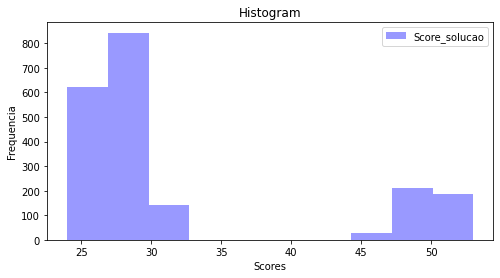

In [43]:
plot_scores(df, score_base='Score_solucao')